# Comparison between SCUBA and SCUBA-2 Cores

This document will serve to compare the Field pointing information for the OrionBN dataset, which is built upon the SCUBA dataset for contended starless cores. However, much newer information is present in the SCUBA-2 Dataset for this region, given by Kirk+2016.

Additionally, the SCUBA(-1) dataset will build the basis for the statistics regarding expected detections from the ALMA dataset. Furthermore, since there is a exact mapping between the SCUBA-2 cores from Kirk+2016 to those SCUBA(-1) cores in Nutter+2007 (specifically by the method used to match the cores to one another, see Kirk+2016 for explanation), we can use the SCUBA-2 cores in addition to the SCUBA(-1) cores as comparisons to make, while analysis is ongoing.

# Part 1 - Imports and IO

In [57]:
import pathlib
from astropy.table import QTable
from astropy.coordinates import SkyCoord
import pandas as pd
import astropy.units as u
from astropy.io import fits
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from astropy.wcs import WCS
import numpy as np


This will load the data into the Catalog Class instances.

In [2]:

RA_STRINGS = ['_RAJ20001', '_RAJ2000', 'RAJ2000', 'RA_Deg', 'ra']
DEC_STRINGS = ['_DEJ20001', '_DEJ2000', 'DEJ2000', 'DEC_Deg', 'dec']
FIELDNAME_STRINGS = ['HOPS', 'Name2', 'Name', 'Name1', 'MJLSG', 'FieldA1', 'Seq', '__NW2007_', 'Source Name', 'SESNA_NAME']

class Catalog:
    def __init__(self,
                 inputpath: pathlib.Path,
                 catalogname: str) -> None:
        
        # load the catalog into QTable
        self.table = QTable.read(inputpath, format='fits', character_as_bytes=False)
        
        # transfer the catalog into DataFrame
        self.frame = self.table.to_pandas()
        
        # set the name of the catalog
        self.name = catalogname
        
        # pull column names for dataframe
        self.ra_col_name = self.frame.columns.intersection(RA_STRINGS)[0]
        self.dec_col_name = self.frame.columns.intersection(DEC_STRINGS)[0]
        self.name_col_name = self.frame.columns.intersection(FIELDNAME_STRINGS)[0]
        
        # generate quantity arrays for ra and dec values in catalog
        self.q_ra = self.frame[self.ra_col_name].values * u.deg
        self.q_dec = self.frame[self.dec_col_name].values * u.deg
        
        # generate skycoord(s)
        self.sc = SkyCoord(self.q_ra, self.q_dec, frame='icrs')
                
    def __str__(self) -> str:
        return f'Catalog Name : {self.name} --- Total Objects: {len(self.sc)}'
    
    def matchsources(self, catalog):
        
        # gather the source names for main catalog
        names = self.frame[self.name_col_name].values
        
        # create DataFrame for associations if not yet found
        if hasattr(self, 'associations'):
            pass
        else:
            self.associations = pd.DataFrame({'Source Name' : names}, index=range(len(names)))

        # gather the source names for the given catalog
        namecol2 = catalog.frame.columns.intersection(FIELDNAME_STRINGS)[0]
        names2 = catalog.frame[namecol2].values
        
        # perform catalog matching
        idx, d2d, d3d = self.sc.match_to_catalog_sky(catalog.sc)
        
        sep_amt_arcsec = d2d.arcsec
        sep_name = names2[idx]
        
        self.associations[f'{catalog.name} Source Name'] = sep_name
        self.associations[f'{catalog.name} Source Separation'] = sep_amt_arcsec
        
        return

In [3]:
path_scuba = pathlib.Path('/Users/samuelfielder/Documents/analysis/catalogues/final/Scuba-Nutter2007_TRIMMED.fit')
c1 = Catalog(path_scuba, 'SCUBA1')
# convert to dataframe
d1 = c1.frame

path_scuba2 = pathlib.Path('/Users/samuelfielder/Documents/analysis/catalogues/final/Scuba2-Kirk2016.fit')
c2 = Catalog(path_scuba2, 'SCUBA2')
# convert to dataframe
d2 = c2.frame

# Part 2 - Computing Concentration and Number Density for SCUBA-2 Cores

The mass for SCUBA-2 cores comes directly from Kirk+2016 (although not given in data):

$$
M = \frac{s_{\nu}D^2}{\kappa_{\nu} B_{\nu}(T)} \\
M = 1.06 \times S_{850 \mu m} \times (e^{\frac{17 \ K}{T}}-1) \times (\kappa_{850 \mu m}/0.0125 \ \text{cm}^2 \ \text{g}^{-1})^{-1} \times (D/415 \ \text{pc})^2
$$

Additionally, the core concentration also comes directly from Kirk+2016 (although not given in data):

$$
C = 1 - \frac{1.13 B^2 F_{\text{tot}}}{\pi R^2 F_{\text{pk}}}
$$

The specific beamwidth for the SCUBA-2 dataset is 14.6 arcsec.

Finally, the number density can be computed from the following:

$$
n = \frac{3}{4\pi \mu m_H} \frac{M}{R_{\text{eff}}^3}
$$

In [4]:
def scuba2mass(peak, distance, kappa, temperature):
    """Computes SCUBA-2 core mass, according to eq given in Kirk+2016

    Parameters
    ----------
    peak : Peak Flux (Jy/beam)
    distance : (pc)
    kappa : (cm^2 g^-1)
    temperature : (K)
    """
    return 1.06 * peak * np.expm1(17/temperature) * ((distance/415)**2) / (kappa/0.0125)

def scuba2concentration(beamsize, total_flux, radius, peak_flux):
    """Computes SCUBA-2 core concentration, according to eq given in Kirk+2016

    Parameters
    ----------
    beamsize : Effective Beam Width (arcsec)
    total_flux : Integrated Flux (Jy)
    radius : Effective Radius (pc)
    peak_flux : Peak Flux (Jy/beam)
    """
    num = 1.13 * (beamsize**2) * total_flux
    radius_arcsec = radius * (60/0.12) # 7.5arcmin per 0.9 pc
    denom = np.pi * (radius_arcsec**2) * peak_flux
    frac = num/denom
    return 1-frac

def numberdensity(mass, radius):
    """Computes number density assuming mu = 2.37.

    Parameters
    ----------
    mass : Integrated Mass (Solar Mass)
    radius : Effective Radius (pc)
    """
    MU = 2.37
    MH = 1.6725575e-24 # g
    m = mass * 1.989e+33 # now in g
    r = radius * 3.086e+18 # now in cm
    # split the division to avoid overflow
    numer = 3 * m / r
    denom = 4 * np.pi * MU * MH * (r**2)
    return numer / denom

# compute core mass and concentration
concentrations = [scuba2concentration(beam, tf, radius, peak) for beam, tf, radius, peak in zip([14.6]*len(d2['F850Tot']), d2['F850Tot'], d2['Reff'], d2['F850Pk'])]
masses = scuba2mass(d2['F850Tot'], 415, 0.0125, 20)

# add to dataframe
d2['Concentration'] = concentrations
d2['Mass'] = masses

# compute number density and add to dataframe
number_density = numberdensity(d2['Mass'].values, d2['Reff'].values)
d2['Number_Density'] = number_density

# Part 3 - Computing Concentration and Number Density for SCUBA(-1) Cores

### Beam Width for SCUBA-1 Instrument:

"The effective FWHMs of the beams in each data set are 17.3'' at 450 μm and 22.9'' at 850 μm." (Di Francesco+2008)

In [77]:
def scuba1radiuspc(maj, min):
    """Computes geometric mean of semi-major axis of source.

    Parameters
    ----------
    maj : Semi-major Axis (arcsec)
    min : Semi-minor Axis (arcsec)
    """
    radii_arcsec = np.sqrt(maj*min)
    radii_radians = radii_arcsec * 4.84814e-6
    radii_pc = radii_radians * 419
    return radii_pc

def scuba1concentration(beamsize, total_flux, radius, peak_flux):
    """Computes SCUBA-1 core concentration, according to eq given in Kirk+2017

    Parameters
    ----------
    beamsize : Effective Beam Width (arcsec)
    total_flux : Integrated Flux (Jy)
    radius : Effective Radius (arcsec)
    peak_flux : Peak Flux (Jy/beam)
    """
    num = 1.13 * (beamsize**2) * total_flux
    radius_arcsec = radius * (444/0.9) # 7.4arcminute per 0.9 pc OR 444 arcsecs per 0.9pc
    denom = np.pi * (radius_arcsec**2) * peak_flux
    frac = num/denom
    return 1-frac

# compute the radii (in pc) and concentration
radii = scuba1radiuspc(d1['amaj'], d1['bmaj'])
# which value am I using for the beamwidth of SCUBA??
concentrations = [scuba1concentration(beam, tf, radius, peak) for beam, tf, radius, peak in zip([14.6]*len(d1['I850']), d1['I850'], radii, d1['P850'])]
# add to dataframe
d1['Reff'] = radii
d1['Concentration'] = concentrations

# compute number density and add to dataframe
number_density = numberdensity(d1['Mass'].values, d1['Reff'].values)
d1['Number_Density'] = number_density

# Part 4 - Inspecting SCUBA(-1) Cores

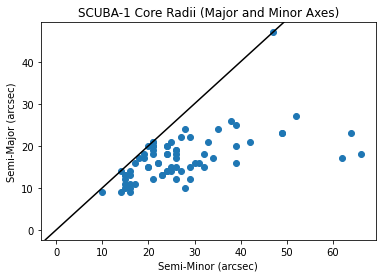

In [47]:
plt.scatter(d1['amaj'], d1['bmaj'])
plt.ylabel('Semi-Major (arcsec)')
plt.xlabel('Semi-Minor (arcsec)')
plt.title('SCUBA-1 Core Radii (Major and Minor Axes)')
plt.axline((0,0), (10,10), color='k')
plt.show()

There are definite outliers here.

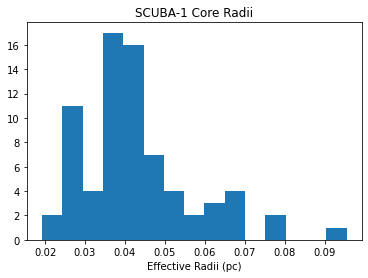

In [48]:
plt.hist(d1['Reff'], bins=15)
plt.title('SCUBA-1 Core Radii')
plt.xlabel('Effective Radii (pc)')
plt.show()

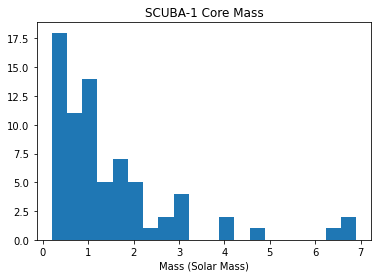

In [49]:
plt.hist(d1['Mass'], bins=20)
plt.title('SCUBA-1 Core Mass')
plt.xlabel('Mass (Solar Mass)')
plt.show()

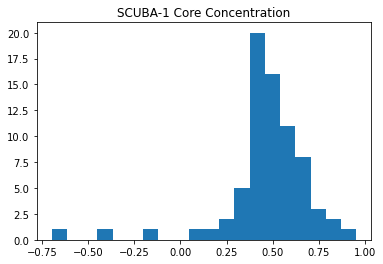

In [78]:
plt.hist(d1['Concentration'], bins=20)
plt.title('SCUBA-1 Core Concentration')
plt.show()

There are notably a couple negative entries here. This just means that the ratio of the integrated flux over the radius^2 and peak flux was not less than 0.0053.

# Part 5 - Computing Associations

Matching will be done using the segmentation map from the FellWalker algorithm. This is guided by Kirk_2016, in which this technique was used to match all SCUBA(-1) cores to a SCUBA-2 core. It is not a 1-to-1 match, but it is very close.

In [9]:
# load in the segmentation map from Kirk+2016
seg_data = fits.getdata('OrionB_N2068_20150914_850_LR1_FellWalker_HK.fits')
seg_header = fits.getheader('OrionB_N2068_20150914_850_LR1_FellWalker_HK.fits')

# generate WCS class to switch between pixel and world value
wcs = WCS(seg_header, naxis=2) # only the ra and dec information, so slice with naxis

# convert SkyCoords of c1 to pixels in the c2 reference frame
c1_pixels = wcs.world_to_pixel(c1.sc)
c1_pixels_x = c1_pixels[0].astype(int)
c1_pixels_y = c1_pixels[1].astype(int)

# find the SCUBA-2 Core reference values for each SCUBA(-1) core
c1_pixelval = [int(seg_data[x,y]) for x,y in zip(c1_pixels_y, c1_pixels_x)] # no idea why I have to pass it in backwards...

Set OBSGEO-B to    19.822855 from OBSGEO-[XYZ].
Set OBSGEO-H to       -3.003 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [10]:
# trim the c2 to only be in the N2068/2071 area
d2_trim = d2[d2['Region'] == 'N2068/2071']

In [11]:
# grabbing all relevant information and building association dataframe
match_scuba2core = []
match_yso = []
match_cat = []
match_mass = []
match_radius = []
match_concentration = []
match_number_density = []
row_data = []

# loop through all scuba2 core identifiers
for s in c1_pixelval:
    # grab the row
    row=d2_trim.loc[d2_trim['Seq'] == s]
    
    # grab the matched scuba2 core information
    match_scuba2core.append(row['MJLSG'].values[0])
    match_yso.append(row['YSO'].values[0])
    match_cat.append(row['YSOCat'].values[0])
    match_mass.append(row['Mass'].values[0])
    match_radius.append(row['Reff'].values[0])
    match_concentration.append(row['Concentration'].values[0])
    match_number_density.append(row['Number_Density'].values[0])
    row_data.append(row)

# add to dataframe
d1['SCUBA2 Core'] = match_scuba2core
d1['SCUBA2 YSO Flag'] = match_yso
d1['SCUBA2 YSO Cat'] = match_cat
d1['SCUBA2 Mass'] = match_mass
d1['SCUBA2 Radii'] = match_radius
d1['SCUBA2 Concentration'] = match_concentration
d1['SCUBA2 Number Density'] = match_number_density

# Part 6 - Comparing Matched SCUBA(-1) and SCUBA-2 Cores

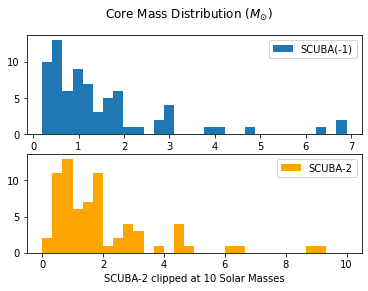

In [12]:
bins=30
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.hist(d1['Mass'], bins=bins, label='SCUBA(-1)')
ax2.hist(d1['SCUBA2 Mass'], bins=bins, range=(0,10), label='SCUBA-2', color='orange')

ax1.legend()
ax2.legend()
fig.suptitle(r'Core Mass Distribution ($M_{\odot}$)')
ax2.set_xlabel('SCUBA-2 clipped at 10 Solar Masses')
plt.show()

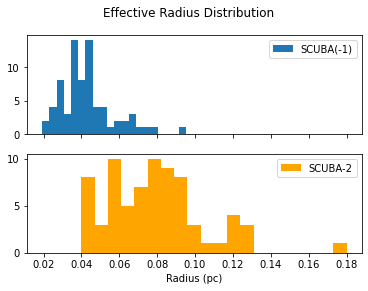

In [19]:
bins=20
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.hist(d1['Reff'], bins=bins, label='SCUBA(-1)')
ax2.hist(d1['SCUBA2 Radii'], bins=bins, label='SCUBA-2', color='orange')

ax1.legend()
ax2.legend()
fig.suptitle(r'Effective Radius Distribution')
ax2.set_xlabel('Radius (pc)')
plt.show()

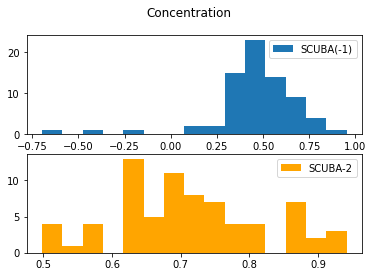

In [80]:
bins=15
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.hist(d1['Concentration'], bins=bins, label='SCUBA(-1)')
ax2.hist(d1['SCUBA2 Concentration'], bins=bins, label='SCUBA-2', color='orange')

ax1.legend()
ax2.legend()
fig.suptitle(r'Concentration')
plt.show()

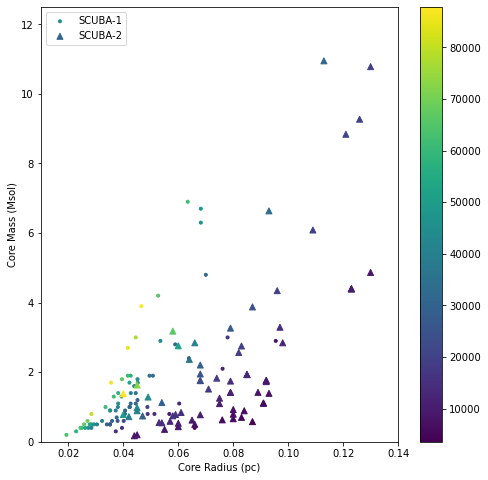

In [76]:
# set up the colorbar
#cmap = plt.get_cmap('cividis')
#norm = plt.Normalize(np.min([d1['Number_Density'], d1['SCUBA2 Number Density']]), np.max([d1['Number_Density'], d1['SCUBA2 Number Density']]))
#color = cmap(200)

plt.figure(figsize=(8,8))
plt.scatter(d1['Reff'], d1['Mass'], c=d1['Number_Density'], marker='.', label='SCUBA-1')
plt.scatter(d1['SCUBA2 Radii'], d1['SCUBA2 Mass'], c=d1['SCUBA2 Number Density'], marker='^', label='SCUBA-2')
plt.colorbar()
plt.xlim(0.01,0.14)
plt.ylim(0,12.5)
plt.xlabel('Core Radius (pc)')
plt.ylabel('Core Mass (Msol)')
plt.legend(loc='upper left')
plt.show()

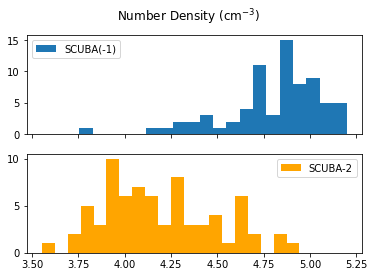

In [81]:
bins=20
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.hist(np.log10(d1['Number_Density']), bins=bins, label='SCUBA(-1)')
ax2.hist(np.log10(d1['SCUBA2 Number Density']), bins=bins, label='SCUBA-2', color='orange')

ax1.legend()
ax2.legend()
fig.suptitle(r'Number Density (cm$^{-3}$)')
#ax2.set_xlabel('Radius (pc)')
plt.show()

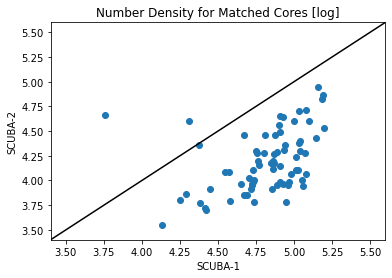

In [89]:
plt.scatter(np.log10(d1['Number_Density']), np.log10(d1['SCUBA2 Number Density']))
plt.axline((3.5,3.5), (5.5,5.5), color='k')
plt.title('Number Density for Matched Cores [log]')
plt.xlabel('SCUBA-1')
plt.ylabel('SCUBA-2')
plt.show()

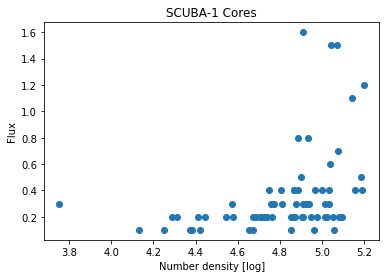

In [95]:
plt.scatter(np.log10(d1['Number_Density']), d1['P850'])
#plt.scatter(np.log10(d1['Number_Density']), d1['I850'])
plt.xlabel('Number density [log]')
plt.ylabel('Flux')
plt.title('SCUBA-1 Cores')
plt.show()

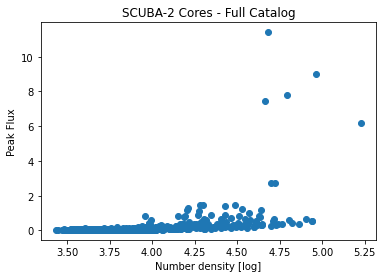

In [93]:
plt.scatter(np.log10(d2['Number_Density']), d2['F850Pk'])
plt.xlabel('Number density [log]')
plt.ylabel('Peak Flux')
plt.title('SCUBA-2 Cores - Full Catalog')
plt.show()

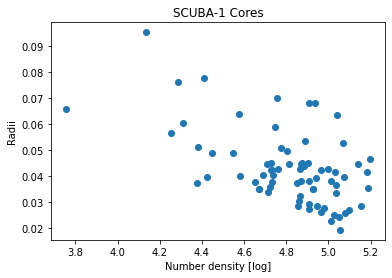

In [98]:
plt.scatter(np.log10(d1['Number_Density']), d1['Reff'])
#plt.scatter(np.log10(d1['Number_Density']), d1['I850'])
plt.xlabel('Number density [log]')
plt.ylabel('Radii')
plt.title('SCUBA-1 Cores')
plt.show()

General trend of higher number density to lower radii.

# Part 7 - Analysis of Lowest Density Objects

In the SCUBA-1 dataset, the lowest core has a number density of 5.6e3, but this is associated with an extremely elongated core, which has a ratio of semi-major axis, to semi-minor axis of 62:17. We can take this as an outlier...

The next lowest density core has a number density of 1.36e4, associated with a perfectly circular source (ratio 47:47 arcsec). This is not found in the group of cores that have the lowest mass in the group, and is somewhat of an outlier with 2.9 Solar Masses.

In [96]:
print((1/(np.exp(1/(20))-1)))
print((1/(np.exp(1/(40))-1)))

19.50416649306586
39.50208331163224
